# Import Libraries

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option("display.max.columns", None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import plotly.graph_objects as go

from tapy import Indicators

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, 
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix
)

import xgboost
from xgboost import XGBClassifier

from keras.models import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import to_categorical

# H1 Timeframe

In [2]:
# read in 2019 full year 1 hour timeframe price data
df_h1_feature = pd.read_csv('../data/df_h1_feature.csv', index_col=0)
df_h1_feature.index = pd.to_datetime(df_h1_feature.index)
df_h1_feature = df_h1_feature.dropna()
df_h1_feature.head()

,open,high,low,close,results,hr_of_day,day_of_wk,shift_01,close_shift_01_dist,shift_02,close_shift_02_dist,shift_03,close_shift_03_dist,shift_05,close_shift_05_dist,shift_08,close_shift_08_dist,shift_13,close_shift_13_dist,shift_21,close_shift_21_dist,shift_34,close_shift_34_dist,shift_55,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,sma_03,close_sma_03_dist,sma_05,close_sma_05_dist,sma_08,close_sma_08_dist,sma_13,close_sma_13_dist,sma_21,close_sma_21_dist,sma_34,close_sma_34_dist,sma_55,close_sma_55_dist,sma_89,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,diff,gain,loss,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-01-07 12:00:00,1.0424,1.0428,1.0408,1.0410,1,12,1,1.0423,-1.3,1.0436,-2.6,1.0435,-2.5,1.0429,-1.9,1.0410,0.0,1.0440,-3.0,1.0472,-6.2,1.0434,-2.4,1.0393,1.7,1.0485,-7.5,1.3,-0.1,1.2,-0.6,-0.7,0.6,-1.9,-2.5,-2.6,-1.3,3.0,1.1,0.5,0.4,1.7,3.2,6.2,4.3,3.7,3.6,4.9,-3.8,-0.6,2.4,0.5,-0.1,-0.2,1.1,-4.1,-7.9,-4.7,-1.7,-3.6,-4.2,-4.3,-3.0,9.2,5.1,1.3,4.5,7.5,5.6,5.0,4.9,6.2,1.04165,-0.65,1.042300,-1.300000,1.04240,-1.40,1.042125,-1.1250,1.042446,-1.446154,1.043314,-2.314286,1.044912,-3.911765,1.043765,-2.765455,1.042664,-1.664045,0.650000,0.100000,0.75,-0.2750,-0.175000,0.4750,0.321154,0.046154,0.146154,0.796154,0.868132,1.189286,0.914286,1.014286,1.664286,1.597479,2.465611,2.786765,2.511765,2.611765,3.261765,-1.146310,0.451169,1.319301,1.640455,1.365455,1.465455,2.115455,-1.101410,-2.247720,-0.650241,0.217891,0.539045,0.264045,0.364045,1.014045,-0.0013,0.0000,0.0013,37.068837,44.550170,7.481333,53.994513,16.925676,53.335001,16.266164,47.645725,10.576888,24.216833,-12.852004,33.875985,-3.192852,54.632562,17.563725,9.444343,-6.348788,3.095555,-5.689276,-23.428892,-29.118168,-29.777680,-20.333337,9.659152,-13.769740,-19.459016,-20.118528,-10.674185,20.756576,30.415729,6.986837,1.297560,0.638049,10.082392,40.809503,45.204507,45.572811,40.950133,38.286167,37.541264,4.395003,0.368304,4.763308,-4.622678,-4.254374,0.140630,-2.663966,-7.286644,-6.918340,-2.523337,-0.744902,-3.408869,-8.031547,-7.663242,-3.268239
2003-01-07 13:00:00,1.0409,1.0425,1.0408,1.0413,1,13,1,1.0410,0.3,1.0423,-1.0,1.0436,-2.3,1.0416,-0.3,1.0412,0.1,1.0439,-2.6,1.0465,

In [3]:
df_h1_feature.shape

(105518, 184)

In [4]:
df_h1_feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105518 entries, 2003-01-07 12:00:00 to 2019-12-30 16:00:00
Columns: 184 entries, open to rsi_14_sma_21m02
dtypes: float64(181), int64(3)
memory usage: 148.9 MB


In [5]:
non_feature = ['open', 'high', 'low', 'close', 'results',
               'shift_01', 'shift_02', 'shift_03', 'shift_05', 
               'shift_08', 'shift_13', 'shift_21', 'shift_34',
               'shift_55', 'shift_89'
               'sma_02', 'sma_03', 'sma_05', 'sma_08', 
               'sma_13', 'sma_21', 'sma_34', 'sma_55', 'sma_89',
               'diff','gain','loss']
features = [col for col in df_h1_feature.columns if col not in non_feature]

X = df_h1_feature[features]
y = df_h1_feature['results']

## Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False )

In [7]:
X_train.head()

,hr_of_day,day_of_wk,close_shift_01_dist,close_shift_02_dist,close_shift_03_dist,close_shift_05_dist,close_shift_08_dist,close_shift_13_dist,close_shift_21_dist,close_shift_34_dist,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,close_sma_03_dist,close_sma_05_dist,close_sma_08_dist,close_sma_13_dist,close_sma_21_dist,close_sma_34_dist,close_sma_55_dist,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-01-07 12:00:00,12,1,-1.3,-2.6,-2.5,-1.9,0.0,-3.0,-6.2,-2.4,1.7,1.0485,-7.5,1.3,-0.1,1.2,-0.6,-0.7,0.6,-1.9,-2.5,-2.6,-1.3,3.0,1.1,0.5,0.4,1.7,3.2,6.2,4.3,3.7,3.6,4.9,-3.8,-0.6,2.4,0.5,-0.1,-0.2,1.1,-4.1,-7.9,-4.7,-1.7,-3.6,-4.2,-4.3,-3.0,9.2,5.1,1.3,4.5,7.5,5.6,5.0,4.9,6.2,1.04165,-0.65,-1.300000,-1.40,-1.1250,-1.446154,-2.314286,-3.911765,-2.765455,-1.664045,0.650000,0.100000,0.75,-0.2750,-0.175000,0.4750,0.321154,0.046154,0.146154,0.796154,0.868132,1.189286,0.914286,1.014286,1.664286,1.597479,2.465611,2.786765,2.511765,2.611765,3.261765,-1.146310,0.451169,1.319301,1.640455,1.365455,1.465455,2.115455,-1.101410,-2.247720,-0.650241,0.217891,0.539045,0.264045,0.364045,1.014045,37.068837,44.550170,7.481333,53.994513,16.925676,53.335001,16.266164,47.645725,10.576888,24.216833,-12.852004,33.875985,-3.192852,54.632562,17.563725,9.444343,-6.348788,3.095555,-5.689276,-23.428892,-29.118168,-29.777680,-20.333337,9.659152,-13.769740,-19.459016,-20.118528,-10.674185,20.756576,30.415729,6.986837,1.297560,0.638049,10.082392,40.809503,45.204507,45.572811,40.950133,38.286167,37.541264,4.395003,0.368304,4.763308,-4.622678,-4.254374,0.140630,-2.663966,-7.286644,-6.918340,-2.523337,-0.744902,-3.408869,-8.031547,-7.663242,-3.268239
2003-01-07 13:00:00,13,1,0.3,-1.0,-2.3,-0.3,0.1,-2.6,-5.2,-4.6,3.7,1.0487,-7.4,1.3,1.3,2.6,-2.0,-0.7,0.6,-0.4,-2.4,-1.1,0.2,2.7,2.3,0.3,1.6,2.9,2.6,5.3,4.9,2.9,4.2,5.5,-0.6,2.0,4.7,4.3,2.3,3.6,4.9,-8.3,-8.9,-6.3,-3.6,-4.0,-6.0,-4.7,-3.4,11.1,2.8,2.2,4.8,7.5,7.1,5.1,6.4,7.7,1.04115,0.15,-0.233333,-1.04,-0.8375,-0.946154,-1.766667,-3.476471,-2.532727,-1.280899,0.383333,0.806667,1.19,-0.2025,0.604167,0.9875,0.108654,-0.093846,0.712821,1.096154,0.820513,0.929167,0.726667,1.533333,1.916667,1.709804

In [8]:
print(X_train.shape)
print(X_test.shape)

(79138, 159)
(26380, 159)


In [9]:
y_train.value_counts(normalize=True)

1    0.411332
2    0.396017
0    0.192651
Name: results, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

0    0.444655
1    0.282070
2    0.273275
Name: results, dtype: float64

## Standard Scaler

In [11]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

## RNN

### un-randomized train set

In [12]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 1

In [13]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=256)

In [14]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=256)

In [15]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [17]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [18]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
310/310 [==============================] - 13s 42ms/step - loss: 1.5248 - categorical_accuracy: 0.4152 - val_loss: 1.2366 - val_categorical_accuracy: 0.2857
Epoch 2/50
310/310 [==============================] - 11s 34ms/step - loss: 1.0491 - categorical_accuracy: 0.4129 - val_loss: 1.1678 - val_categorical_accuracy: 0.2859
Epoch 3/50
310/310 [==============================] - 11s 34ms/step - loss: 1.0241 - categorical_accuracy: 0.4176 - val_loss: 1.1471 - val_categorical_accuracy: 0.3106
Epoch 4/50
310/310 [==============================] - 11s 34ms/step - loss: 1.0136 - categorical_accuracy: 0.4272 - val_loss: 1.1331 - val_categorical_accuracy: 0.3842
Epoch 5/50
310/310 [==============================] - 9s 29ms/step - loss: 1.0071 - categorical_accuracy: 0.4275 - val_loss: 1.1214 - val_categorical_accuracy: 0.3885
Epoch 6/50
310/310 [==============================] - 8s 25ms/step - loss: 1.0033 - c

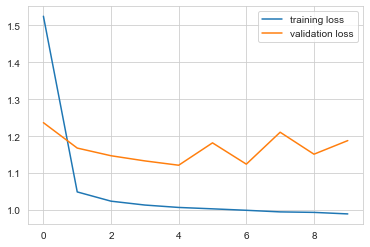

In [19]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

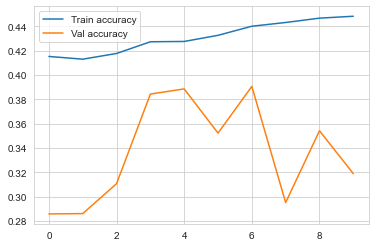

In [20]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [21]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,1260,7440,3030
actual 1,423,4780,2237
actual 2,545,4294,2370


In [22]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.2894513745912559

In [23]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.3103312819169831

In [24]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.29605399362345247

In [25]:
rnn_proba = model.predict_proba(test_sequence)

Instructions for updating:
Please use `model.predict()` instead.


In [26]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.163627,0.418824,0.417549
1,0.148874,0.433878,0.417248
2,0.158672,0.418452,0.422876
3,0.134411,0.432746,0.432843
4,0.132807,0.437986,0.429207


In [27]:
results_compare = pd.DataFrame(X_test["hr_of_day"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [28]:
results_compare.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 17:00:00,17,1,1,1,0.163627,0.418824,0.417549
2015-10-01 18:00:00,18,1,1,1,0.148874,0.433878,0.417248
2015-10-01 19:00:00,19,1,2,0,0.158672,0.418452,0.422876
2015-10-01 20:00:00,20,1,2,0,0.134411,0.432746,0.432843
2015-10-01 21:00:00,21,1,1,1,0.132807,0.437986,0.429207


In [29]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 17:00:00,17,1,1,1,0.163627,0.418824,0.417549
2015-10-01 18:00:00,18,1,1,1,0.148874,0.433878,0.417248
2015-10-01 21:00:00,21,1,1,1,0.132807,0.437986,0.429207
2015-10-01 23:00:00,23,1,1,1,0.143436,0.435999,0.420565
2015-10-02 00:00:00,0,1,1,1,0.161231,0.425522,0.413247


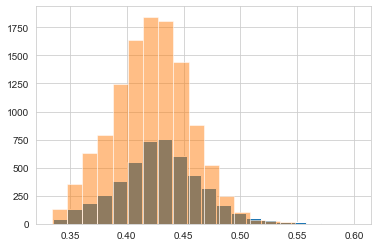

In [30]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [31]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 19:00:00,19,1,2,0,0.158672,0.418452,0.422876
2015-10-01 20:00:00,20,1,2,0,0.134411,0.432746,0.432843
2015-10-01 22:00:00,22,1,2,0,0.128275,0.432434,0.439291
2015-10-02 01:00:00,1,1,2,0,0.155879,0.418187,0.425934
2015-10-02 02:00:00,2,1,2,0,0.145608,0.420303,0.434089


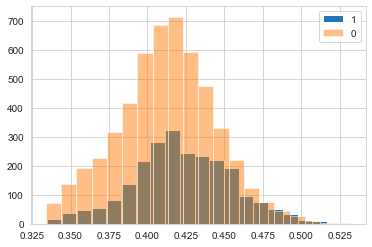

In [32]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [33]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 3

In [34]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=256)

In [35]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=256)

In [36]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [37]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [38]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
310/310 [==============================] - 9s 28ms/step - loss: 1.6577 - categorical_accuracy: 0.4082 - val_loss: 1.3311 - val_categorical_accuracy: 0.2917
Epoch 2/50
310/310 [==============================] - 10s 32ms/step - loss: 1.0885 - categorical_accuracy: 0.4201 - val_loss: 1.1494 - val_categorical_accuracy: 0.3205
Epoch 3/50
310/310 [==============================] - 11s 35ms/step - loss: 1.0274 - categorical_accuracy: 0.4216 - val_loss: 1.1758 - val_categorical_accuracy: 0.2974
Epoch 4/50
310/310 [==============================] - 12s 38ms/step - loss: 1.0124 - categorical_accuracy: 0.4306 - val_loss: 1.2490 - val_categorical_accuracy: 0.2861
Epoch 5/50
310/310 [==============================] - 12s 40ms/step - loss: 1.0033 - categorical_accuracy: 0.4345 - val_loss: 1.4988 - val_categorical_accuracy: 0.2803
Epoch 6/50
310/310 [==============================] - 13s 42ms/step - loss: 0.9974 - categorical_accuracy: 0.4404 - val_loss: 1.2811 - val_categorical_accuracy: 

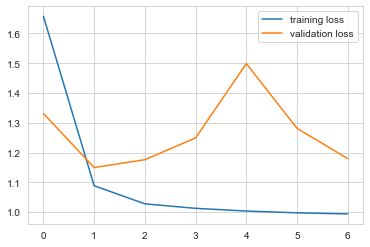

In [39]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

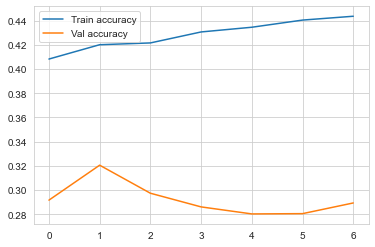

In [40]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [41]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,373,10890,467
actual 1,119,6934,385
actual 2,166,6718,325


In [42]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.2825360606307554

In [43]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.27612574341546303

In [44]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.2822426999494537

In [45]:
rnn_proba = model.predict_proba(test_sequence)

In [46]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.200054,0.416226,0.383720
1,0.200031,0.416087,0.383882
2,0.202688,0.414622,0.382690
3,0.196429,0.417690,0.385881
4,0.198515,0.415198,0.386286


In [47]:
results_compare = pd.DataFrame(X_test["hr_of_day"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [48]:
results_compare.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 19:00:00,19,1,1,1,0.200054,0.416226,0.383720
2015-10-01 20:00:00,20,1,1,1,0.200031,0.416087,0.383882
2015-10-01 21:00:00,21,1,1,1,0.202688,0.414622,0.382690
2015-10-01 22:00:00,22,1,1,1,0.196429,0.417690,0.385881
2015-10-01 23:00:00,23,1,1,1,0.198515,0.415198,0.386286


In [49]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 19:00:00,19,1,1,1,0.200054,0.416226,0.383720
2015-10-01 20:00:00,20,1,1,1,0.200031,0.416087,0.383882
2015-10-01 21:00:00,21,1,1,1,0.202688,0.414622,0.382690
2015-10-01 22:00:00,22,1,1,1,0.196429,0.417690,0.385881
2015-10-01 23:00:00,23,1,1,1,0.198515,0.415198,0.386286


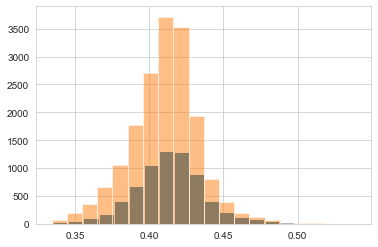

In [50]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [51]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-02 07:00:00,7,1,2,0,0.246039,0.375913,0.378048
2015-10-02 08:00:00,8,2,2,1,0.264803,0.362923,0.372274
2015-10-15 09:00:00,9,0,2,0,0.240051,0.373882,0.386067
2015-10-15 10:00:00,10,2,2,1,0.242728,0.364463,0.392809
2015-10-15 11:00:00,11,2,2,1,0.227731,0.367516,0.404753


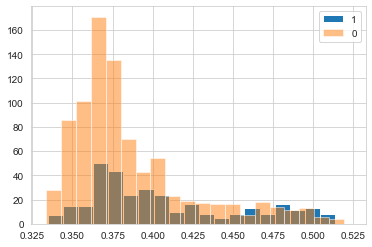

In [52]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [53]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 5

In [54]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=256)

In [55]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=256)

In [56]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [57]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [58]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
310/310 [==============================] - 22s 72ms/step - loss: 1.7195 - categorical_accuracy: 0.4031 - val_loss: 1.4094 - val_categorical_accuracy: 0.2936
Epoch 2/50
310/310 [==============================] - 22s 72ms/step - loss: 1.1130 - categorical_accuracy: 0.4208 - val_loss: 1.1961 - val_categorical_accuracy: 0.3009
Epoch 3/50
310/310 [==============================] - 22s 71ms/step - loss: 1.0333 - categorical_accuracy: 0.4234 - val_loss: 1.1838 - val_categorical_accuracy: 0.2895
Epoch 4/50
310/310 [==============================] - 22s 71ms/step - loss: 1.0124 - categorical_accuracy: 0.4344 - val_loss: 1.2176 - val_categorical_accuracy: 0.2968
Epoch 5/50
310/310 [==============================] - 22s 70ms/step - loss: 1.0032 - categorical_accuracy: 0.4358 - val_loss: 1.2383 - val_categorical_accuracy: 0.2907
Epoch 6/50
310/310 [==============================] - 22s 70ms/step - loss: 0.9977 - categorical_accuracy: 0.4400 - val_loss: 1.2398 - val_categorical_accuracy:

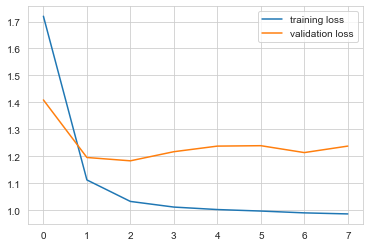

In [59]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

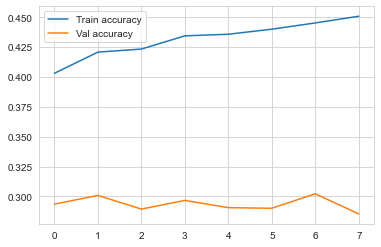

In [60]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [61]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,90,8348,3292
actual 1,36,5081,2319
actual 2,57,4795,2357


In [62]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.2788081650570676

In [63]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.2958082329317269

In [64]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.2839798411728772

In [65]:
rnn_proba = model.predict_proba(test_sequence)

In [66]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.129635,0.417077,0.453287
1,0.120604,0.414444,0.464953
2,0.127091,0.411175,0.461734
3,0.128489,0.411876,0.459635
4,0.130845,0.415790,0.453365


In [67]:
results_compare = pd.DataFrame(X_test["hr_of_day"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [68]:
results_compare.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 21:00:00,21,1,2,0,0.129635,0.417077,0.453287
2015-10-01 22:00:00,22,1,2,0,0.120604,0.414444,0.464953
2015-10-01 23:00:00,23,1,2,0,0.127091,0.411175,0.461734
2015-10-02 00:00:00,0,1,2,0,0.128489,0.411876,0.459635
2015-10-02 01:00:00,1,1,2,0,0.130845,0.415790,0.453365


In [69]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-02 11:00:00,11,2,1,0,0.310303,0.357468,0.332229
2015-10-02 14:00:00,14,1,1,1,0.203358,0.429627,0.367016
2015-10-02 15:00:00,15,1,1,1,0.119871,0.469040,0.411089
2015-10-02 16:00:00,16,1,1,1,0.118944,0.461546,0.419510
2015-10-04 17:00:00,17,1,1,1,0.086603,0.477320,0.436077


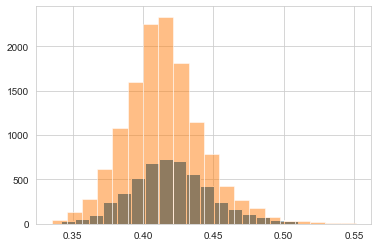

In [70]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [71]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 21:00:00,21,1,2,0,0.129635,0.417077,0.453287
2015-10-01 22:00:00,22,1,2,0,0.120604,0.414444,0.464953
2015-10-01 23:00:00,23,1,2,0,0.127091,0.411175,0.461734
2015-10-02 00:00:00,0,1,2,0,0.128489,0.411876,0.459635
2015-10-02 01:00:00,1,1,2,0,0.130845,0.415790,0.453365


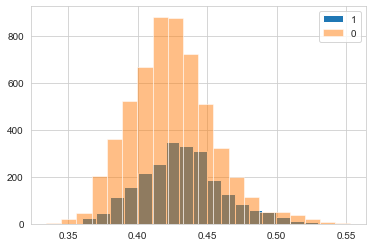

In [72]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [73]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 7

In [74]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=256)

In [75]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=256)

In [76]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [77]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [78]:
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
310/310 [==============================] - 29s 92ms/step - loss: 1.7318 - categorical_accuracy: 0.4069 - val_loss: 1.3694 - val_categorical_accuracy: 0.3053
Epoch 2/50
310/310 [==============================] - 28s 91ms/step - loss: 1.1258 - categorical_accuracy: 0.4275 - val_loss: 1.3071 - val_categorical_accuracy: 0.2950
Epoch 3/50
310/310 [==============================] - 29s 92ms/step - loss: 1.0358 - categorical_accuracy: 0.4266 - val_loss: 1.2200 - val_categorical_accuracy: 0.2942
Epoch 4/50
310/310 [==============================] - 29s 93ms/step - loss: 1.0137 - categorical_accuracy: 0.4327 - val_loss: 1.2298 - val_categorical_accuracy: 0.2809
Epoch 5/50
310/310 [==============================] - 29s 93ms/step - loss: 0.9993 - categorical_accuracy: 0.4460 - val_loss: 1.2904 - val_categorical_accuracy: 0.2811
Epoch 6/50
310/310 [==============================] - 31s 99ms/step - loss: 0.9924 - categorical_accuracy: 0.4480 - val_loss: 1.1782 - val_categorical_accuracy:

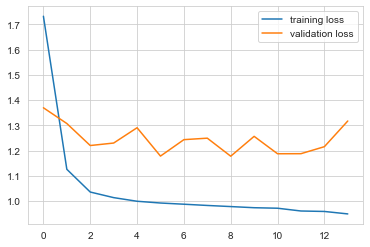

In [79]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

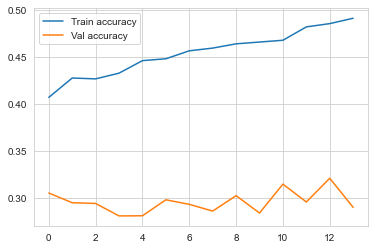

In [80]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [81]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,137,10494,1099
actual 1,99,6198,1137
actual 2,85,5810,1314


In [82]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.27544218291707406

In [83]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.37014084507042255

In [84]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.2883463841547674

In [85]:
rnn_proba = model.predict_proba(test_sequence)

In [86]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.122301,0.441351,0.436348
1,0.112797,0.444549,0.442655
2,0.094416,0.442533,0.463051
3,0.081954,0.436842,0.481205
4,0.084840,0.421122,0.494039


In [87]:
results_compare = pd.DataFrame(X_test["hr_of_day"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [88]:
results_compare.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 23:00:00,23,1,1,1,0.122301,0.441351,0.436348
2015-10-02 00:00:00,0,1,1,1,0.112797,0.444549,0.442655
2015-10-02 01:00:00,1,1,2,0,0.094416,0.442533,0.463051
2015-10-02 02:00:00,2,1,2,0,0.081954,0.436842,0.481205
2015-10-02 03:00:00,3,1,2,0,0.084840,0.421122,0.494039


In [89]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-01 23:00:00,23,1,1,1,0.122301,0.441351,0.436348
2015-10-02 00:00:00,0,1,1,1,0.112797,0.444549,0.442655
2015-10-02 07:00:00,7,1,1,1,0.146246,0.442976,0.410777
2015-10-02 08:00:00,8,2,1,0,0.153971,0.433915,0.412114
2015-10-02 09:00:00,9,2,1,0,0.172414,0.444366,0.383219


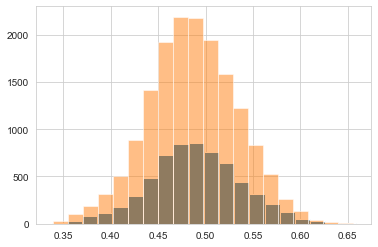

In [90]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [91]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,hr_of_day,results,pred,compare,proba_0,proba_1,proba_2
2015-10-02 01:00:00,1,1,2,0,0.094416,0.442533,0.463051
2015-10-02 02:00:00,2,1,2,0,0.081954,0.436842,0.481205
2015-10-02 03:00:00,3,1,2,0,0.084840,0.421122,0.494039
2015-10-02 04:00:00,4,1,2,0,0.087178,0.409269,0.503553
2015-10-02 05:00:00,5,1,2,0,0.098142,0.410907,0.490951


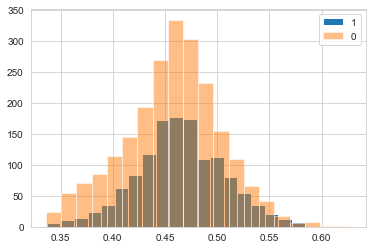

In [92]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

In [93]:
ratio = results_compare.groupby('hr_of_day')['compare'].agg(['count', 'sum'])
ratio['rate'] = ratio['sum']/ratio['count']
ratio

,count,sum,rate
hr_of_day,,,
0,1100,318,0.289091
1,1100,310,0.281818
2,1100,307,0.279091
3,1098,309,0.281421
4,1098,312,0.284153
5,1098,300,0.273224
6,1099,312,0.283894
7,1099,333,0.303003
8,1099,307,0.279345


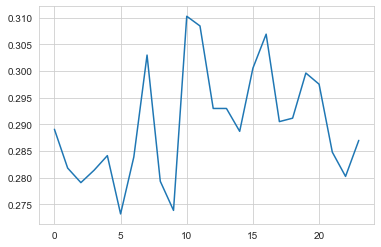

In [94]:
plt.plot(ratio.index, ratio['rate'])